# Security and Privacy Implications Part 1 (Channel capacity perspective)
In this notebook, we analyze the impact of the channel linking and lightning node clustering.
We do so by calculating the shares of capacity controlled by the largest entities, and analyzing the 
impact of griefing attacks, and the effects on the network structure, routable capacity and payment success when assuming entire entities are taken offline.
1. Data
2. Compute entity (cluster) capacity shares (a.k.a. wealth distribution)
3. Impact of Griefing attacks
4. Component disintegration
5. Average maximum flow with uniform random sampling
6. Expected payment success ratio
7. Combine results and plot

In [7]:
import sys
sys.path.append("..")

# input files
from utils import snapshot_csv_file, alias_address_clusters_csv_file, \
    funding_node_channel_csv_file

import pandas as pd
import numpy as np
import random
from igraph import *
from itertools import combinations
from tqdm.notebook import tqdm
import copy

from utils import make_cluster_aliases

## plotting
from plotnine import *
from mizani.formatters import percent_format

theme_publication = theme_bw() + theme(text=element_text(family="cmr10", size=12, color="black"),
                                       axis_title=element_text(size=14))

In [8]:
from igraph import Graph

# 1. Data
In this section, we load a lightning snapshot, a lightning node clustering, and list of channels with identified funding nodes.

#### Inputs (made available):
- `snapshot_csv_file` This is a lightning network snapshot from September 9, 2020
- `alias_address_clusters_csv_file`
- `funding_node_channel_csv_file`

#### Outputs:
- The outputs of this notebooks are plots and tables

Please be aware that running all cells some might take several hours to complete, look for the \*\*WARNING** comment in the cells).

In [2]:
# input files
edgelist = pd.read_csv(snapshot_csv_file)
aliasip_clusters = pd.read_csv(alias_address_clusters_csv_file)
capacity_from_linking = pd.read_csv(funding_node_channel_csv_file)

In [9]:
# Preprocessing
edgelist = edgelist.rename(columns={"node1_pub":"node1", "node2_pub":"node2"})
edgelist = edgelist[["node1", "node2", "capacity", "chan_point"]]

# Create an igraph object based on the edge list, where the edge weight is its capacity
tuples = [tuple(x) for x in edgelist[["node1", "node2", "capacity"]].values]
g = Graph.TupleList(tuples, directed = False, edge_attrs = ['weight'])

id_to_name = dict(map(lambda x: (x.index, x['name']), list(g.vs)))
name_to_id = {v: k for k, v in id_to_name.items()}

# Find which entities exist in the current snapshot
existing_entities = aliasip_clusters[aliasip_clusters.pub_key.isin([id_to_name[v.index] for v in g.vs()])]
existing_entities = existing_entities.groupby("cluster").filter(lambda x: len(x) > 1)
cluster_aliases = make_cluster_aliases(existing_entities)

In [4]:
# Global statistics
totalCapacity = edgelist.capacity.sum()
totalChannels = len(edgelist)
print("The snapshot has a total capacity of", totalCapacity, "satoshis, consisting of", totalChannels, "channels.")

The snapshot has a total capacity of 100130793892 satoshis, consisting of 35195 channels.


# 2. Compute entity (cluster) capacity shares

Here we attribute channel capacities to nodes, based on the linking result of who created the channel.
If we don't know who created a channel, we attribute the capacity 50/50 to each participant.

In [5]:
n1c = existing_entities[["pub_key", "cluster"]].rename(columns={"pub_key":"node1", "cluster":"n1_c"})
n2c = existing_entities[["pub_key", "cluster"]].rename(columns={"pub_key":"node2", "cluster":"n2_c"})

capacity_from_linking.rename(columns = {"channel":"chan_point"}, inplace=True)

channel_funders = edgelist.merge(capacity_from_linking, on="chan_point", how="left")
channel_funders = channel_funders.merge(n1c, on="node1", how="left").merge(n2c, on="node2", how="left")

def attribute_channel_capacity_to_node(row):
    capacity = row["capacity"]
    fundingNodeIsKnown = not pd.isnull(row["funding_node"])
    n1cExists = not pd.isnull(row["n1_c"])
    n2cExists = not pd.isnull(row["n2_c"])
    if(fundingNodeIsKnown):
        return({row["funding_node"]:capacity})
    else: 
        return({row["node1"]:capacity/2, row["node2"]:capacity/2})
    
clist = channel_funders.apply(attribute_channel_capacity_to_node, axis=1).tolist()
capacities = pd.DataFrame([(k,v) for x in clist for (k, v) in x.items()], columns = ["pub_key", "capacity"])
node_capacity_share = (capacities.groupby("pub_key")["capacity"].sum()/totalCapacity).reset_index()
cluster_capacity_share = node_capacity_share.merge(existing_entities, on="pub_key", how="inner")
cluster_capacity_share = cluster_capacity_share.groupby("cluster")["capacity"].sum().reset_index()
cluster_capacity_share = cluster_capacity_share.merge(cluster_aliases)
cluster_capacity_share = cluster_capacity_share.sort_values("capacity", ascending=False)

In [6]:
# Table 5. LN users controlling most capcacity.
cluster_capacity_share.head()

,cluster,capacity,cluster_size,alias
46,93,0.240728,26,LNBIG.com [*
21,38,0.042056,2,bfx-lnd*
18,34,0.023755,3,*Bitrefill.com/g...
26,44,0.019766,2,CoinGate
30,53,0.005270,3,Breez*


In [7]:
ncs = node_capacity_share.sort_values("capacity", ascending=False)
ncs["cumushare"] = ncs["capacity"].cumsum()
ncs = ncs.reset_index(drop=True)
print(ncs[ncs["cumushare"] >= 0.8].iloc[0].name + 1, "of", g.vcount(), "nodes control 80% of capacity.")

237 of 7380 nodes control 80% of capacity.


# 3. Impact of Griefing attacks
Here, we simulate the griefing attack and compute the share of channels and capacity that can be locked by each entity.

In [8]:
def performMaxFlowAndUpdateWeights(g, source, target):
    mf = g.maxflow(source=name_to_id[source],
                   target=name_to_id[target], capacity='weight')
    for (index, flow) in enumerate(mf.flow):
        newCapacity = g.es[index]['weight'] - abs(flow)
        g.es[index].update_attributes({'weight': newCapacity})
        g.es[index].update_attributes({'label': newCapacity})
    
    return(mf.value)

def performGrieving(g, entity_nodes):
    cumulativeFlow = 0
    for (source, target) in tqdm(list(combinations(entity_nodes, 2)), leave=False):
        cumulativeFlow += performMaxFlowAndUpdateWeights(g, source, target)
    return(cumulativeFlow)
    # idea - if you want to send funds to yourself:
    # start max-flow from every neighbor to yourself,
    # setting an upper capacity limit for the neighbor channels
    # to the capacity you have to the neighbor
    
def performGrievingByEntityId(g, eid):
    coins = performGrieving(g, existing_entities[existing_entities.cluster==eid].pub_key.values.tolist())
    cCount = len([edge for edge in g.es if edge["weight"] == 0])
    return({"cluster":eid, "coins":coins, "cCount":cCount})

In [9]:
%%time
# **WARNING**, this may take about 15 minutes
individualGrievingResList = list()
for entity_id in tqdm(existing_entities.cluster.unique().tolist()):
    gcopy = copy.deepcopy(g)
    individualGrievingResList.append(performGrievingByEntityId(gcopy, entity_id))
    
individualGrievingRes = pd.DataFrame(individualGrievingResList)
individualGrievingRes = individualGrievingRes.merge(cluster_aliases, on="cluster")
individualGrievingRes["capacityShare"] = individualGrievingRes["coins"] / totalCapacity
individualGrievingRes["channelShare"] = individualGrievingRes["cCount"] / totalChannels
individualGrievingRes = individualGrievingRes.sort_values("capacityShare", ascending = False)
individualGrievingRes.head()


CPU times: user 15min 13s, sys: 25.1 s, total: 15min 38s
Wall time: 15min 37s


,cluster,coins,cCount,cluster_size,alias,capacityShare,channelShare
46,93,1.396590e+10,14384,26,LNBIG.com [*,0.139477,0.408694
21,38,4.508912e+09,2528,2,bfx-lnd*,0.045030,0.071828
18,34,3.645931e+08,76,3,*Bitrefill.com/g...,0.003641,0.002159
40,70,1.252817e+08,126,2,Syndicate ~ *,0.001251,0.003580
95,219,8.123484e+07,158,2,* | *,0.000811,0.004489


Plotting the results for Figure 6

/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 3.5 in image.
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: griefed_share_combined.pdf


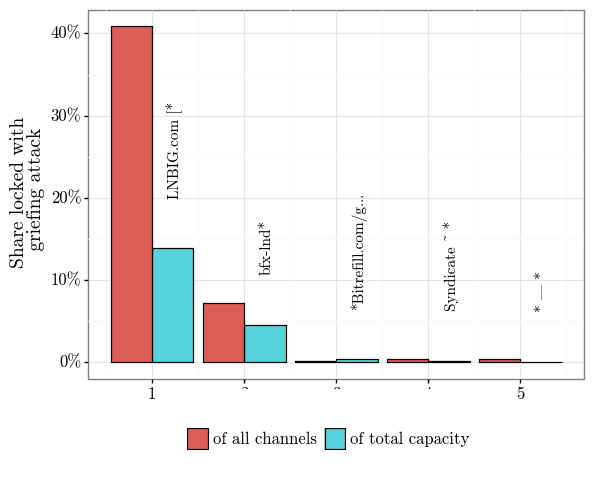

<ggplot: (8794196708762)>

In [10]:
# Figure 6
# Note that the legend and some of the labels of this plot have been improved manually in the paper itself
combined_data = individualGrievingRes.sort_values("capacityShare", ascending=False).head(5)
combined_data = combined_data.reset_index(drop=True).reset_index().rename(columns={"index":"position"})
combined_data["position"] += 1
combined_data = pd.melt(combined_data.rename(columns={"capacityShare":"of total capacity", "channelShare":"of all channels"}),
                        id_vars=["position", "cluster_size", "alias"],
                        value_vars=["of total capacity", "of all channels"])
plot = ggplot(combined_data) +\
geom_bar(aes(x="position", y="value", fill="variable"), position="dodge", stat="identity", color="black") +\
geom_text(data=combined_data[combined_data.variable == "of total capacity"],
          mapping=aes(x="position", y="value", label="alias"), angle=90, va="baseline", nudge_y=0.065, nudge_x=0.25) +\
labs(x="Top entities", y="Share locked with\n griefing attack", fill="") +\
scale_y_continuous(labels=percent_format()) +\
theme_publication +\
theme(legend_position="bottom")

plot.save("griefed_share_combined.pdf", width=5, height=3.5)
plot

# 4. Component disintegration
Here we compute the size of the largest remaining component when iteratively removing entities by largest capacity share.

In [11]:
def count_components(graph):
    return(len(graph.components(mode="WEAK")))

def size_largest_component(graph):
    return(len(graph.clusters().giant().vs()))

localG = copy.deepcopy(g)

original_component_count = count_components(localG) # can be removed?
original_component_size = size_largest_component(localG)

coResult = list()
coResult.append({"cluster":None, "size_largest_component": original_component_size})

for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    entity_pub_keys = existing_entities[existing_entities.cluster==entity_id].pub_key.values.tolist()
    ids_to_delete = [localG.vs.find(pub_key).index for pub_key in entity_pub_keys]
    localG.delete_vertices(ids_to_delete)
    coResult.append({"cluster": entity_id,
                    "size_largest_component": size_largest_component(localG)})

removalStats = pd.DataFrame(coResult)
removalStats["largest component"] = 1 - (removalStats["size_largest_component"] / original_component_size)
removalStats = removalStats.reset_index()

# 5. Average maximum flow with uniform random sampling
Here we pick 1000 randomly chosen pairs of nodes and compute the average maximum flow between them, when iteratively removing entities with the largest capacity share.

In [12]:
%%time
# **WARNING**, this may take about 15 minutes

pairs = 1000

# node pairs except nodes from our clusters
nodePairs = list(combinations([v["name"] for v in g.vs if v["name"] not in existing_entities.pub_key.tolist()], 2))
# draw 
random.seed(0)
randomPairs = random.choices(nodePairs, k=pairs)

def estimateAvgMaxFlow(g):
    avgMaxFlow = np.array(
        [g.maxflow_value(g.vs.find(s).index, g.vs.find(t).index, capacity="weight") for (s, t) in tqdm(randomPairs, leave=False)]).mean()
    return(avgMaxFlow)

localG = copy.deepcopy(g)
mfResults = list()
initialAvgMaxFlow = estimateAvgMaxFlow(localG)
mfResults.append({"cluster":None, "avgMaxFlow": initialAvgMaxFlow})

for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    entity_pub_keys = existing_entities[existing_entities.cluster==entity_id].pub_key.values.tolist()
    vids = [v.index for v in localG.vs if v["name"] in entity_pub_keys]
    localG.delete_vertices(vids)
    stat = {"cluster":entity_id, "avgMaxFlow":estimateAvgMaxFlow(localG)}
    print(stat)
    mfResults.append(stat)

mfResultsDF = pd.DataFrame(mfResults).reset_index()
mfResultsDF["advantage"] = 1 - (mfResultsDF["avgMaxFlow"]/initialAvgMaxFlow)

{'cluster': 93, 'avgMaxFlow': 859404.671}


{'cluster': 38, 'avgMaxFlow': 832610.412}


{'cluster': 34, 'avgMaxFlow': 782520.226}


{'cluster': 44, 'avgMaxFlow': 728791.383}


{'cluster': 53, 'avgMaxFlow': 721425.269}


{'cluster': 37, 'avgMaxFlow': 721299.269}


{'cluster': 100, 'avgMaxFlow': 708896.955}


{'cluster': 56, 'avgMaxFlow': 704270.418}


{'cluster': 86, 'avgMaxFlow': 691413.172}


{'cluster': 0, 'avgMaxFlow': 688911.52}


{'cluster': 210, 'avgMaxFlow': 684518.434}


{'cluster': 50, 'avgMaxFlow': 682807.627}


{'cluster': 278, 'avgMaxFlow': 682807.627}


{'cluster': 285, 'avgMaxFlow': 681933.464}


{'cluster': 255, 'avgMaxFlow': 680933.464}


{'cluster': 70, 'avgMaxFlow': 680933.464}


{'cluster': 184, 'avgMaxFlow': 679719.859}


{'cluster': 96, 'avgMaxFlow': 679484.27}


{'cluster': 219, 'avgMaxFlow': 677728.4}


{'cluster': 14, 'avgMaxFlow': 677608.4}


{'cluster': 131, 'avgMaxFlow': 676737.408}


{'cluster': 180, 'avgMaxFlow': 675523.193}


{'cluster': 123, 'avgMaxFlow': 674963.193}


{'cluster': 288, 'avgMaxFlow': 672202.806}


{'cluster': 94, 'avgMaxFlow': 672192.806}


{'cluster': 98, 'avgMaxFlow': 671945.97}


{'cluster': 74, 'avgMaxFlow': 671945.97}


{'cluster': 244, 'avgMaxFlow': 671024.612}


{'cluster': 165, 'avgMaxFlow': 669954.346}


{'cluster': 24, 'avgMaxFlow': 669366.853}


{'cluster': 277, 'avgMaxFlow': 669245.906}


{'cluster': 172, 'avgMaxFlow': 669115.698}


{'cluster': 144, 'avgMaxFlow': 668745.381}


{'cluster': 46, 'avgMaxFlow': 666745.381}


{'cluster': 136, 'avgMaxFlow': 666745.381}


{'cluster': 121, 'avgMaxFlow': 666495.381}


{'cluster': 146, 'avgMaxFlow': 666495.381}


{'cluster': 102, 'avgMaxFlow': 660025.536}


{'cluster': 208, 'avgMaxFlow': 660025.536}


{'cluster': 225, 'avgMaxFlow': 660025.536}


{'cluster': 61, 'avgMaxFlow': 659825.536}


{'cluster': 103, 'avgMaxFlow': 659825.536}


{'cluster': 35, 'avgMaxFlow': 659780.536}


{'cluster': 169, 'avgMaxFlow': 659780.536}


{'cluster': 261, 'avgMaxFlow': 659780.536}


{'cluster': 39, 'avgMaxFlow': 659780.536}


{'cluster': 183, 'avgMaxFlow': 659698.669}


{'cluster': 31, 'avgMaxFlow': 659698.669}


{'cluster': 223, 'avgMaxFlow': 659452.209}


{'cluster': 279, 'avgMaxFlow': 659452.209}


{'cluster': 270, 'avgMaxFlow': 659452.209}


{'cluster': 221, 'avgMaxFlow': 659452.209}


{'cluster': 158, 'avgMaxFlow': 659193.518}


{'cluster': 29, 'avgMaxFlow': 658843.518}


{'cluster': 201, 'avgMaxFlow': 658773.518}


{'cluster': 40, 'avgMaxFlow': 658773.518}


{'cluster': 259, 'avgMaxFlow': 658773.518}


{'cluster': 209, 'avgMaxFlow': 658773.518}


{'cluster': 286, 'avgMaxFlow': 658773.518}


{'cluster': 59, 'avgMaxFlow': 658772.018}


{'cluster': 11, 'avgMaxFlow': 658772.018}


{'cluster': 60, 'avgMaxFlow': 658772.018}


{'cluster': 16, 'avgMaxFlow': 658772.018}


{'cluster': 117, 'avgMaxFlow': 658772.018}


{'cluster': 252, 'avgMaxFlow': 655891.935}


{'cluster': 230, 'avgMaxFlow': 655723.935}


{'cluster': 242, 'avgMaxFlow': 655723.935}


{'cluster': 170, 'avgMaxFlow': 655723.935}


{'cluster': 8, 'avgMaxFlow': 655723.935}


{'cluster': 291, 'avgMaxFlow': 655723.935}


{'cluster': 274, 'avgMaxFlow': 655723.935}


{'cluster': 228, 'avgMaxFlow': 655723.935}


{'cluster': 43, 'avgMaxFlow': 655723.935}


{'cluster': 135, 'avgMaxFlow': 655723.935}


{'cluster': 206, 'avgMaxFlow': 655723.935}


{'cluster': 258, 'avgMaxFlow': 655723.935}


{'cluster': 87, 'avgMaxFlow': 655691.842}


{'cluster': 240, 'avgMaxFlow': 655691.842}


{'cluster': 284, 'avgMaxFlow': 655691.842}


{'cluster': 236, 'avgMaxFlow': 655691.842}


{'cluster': 28, 'avgMaxFlow': 652876.082}


{'cluster': 182, 'avgMaxFlow': 652876.082}


{'cluster': 107, 'avgMaxFlow': 652856.082}


{'cluster': 68, 'avgMaxFlow': 652856.082}


{'cluster': 198, 'avgMaxFlow': 652856.082}


{'cluster': 203, 'avgMaxFlow': 652856.082}


{'cluster': 67, 'avgMaxFlow': 652556.082}


{'cluster': 42, 'avgMaxFlow': 652516.082}


{'cluster': 262, 'avgMaxFlow': 652516.082}


{'cluster': 232, 'avgMaxFlow': 652516.082}


{'cluster': 82, 'avgMaxFlow': 652516.082}


{'cluster': 233, 'avgMaxFlow': 652516.082}


{'cluster': 30, 'avgMaxFlow': 652516.082}


{'cluster': 200, 'avgMaxFlow': 652516.082}


{'cluster': 54, 'avgMaxFlow': 652516.082}


{'cluster': 287, 'avgMaxFlow': 652116.082}


{'cluster': 256, 'avgMaxFlow': 651985.11}


{'cluster': 149, 'avgMaxFlow': 651585.11}


{'cluster': 19, 'avgMaxFlow': 651585.11}


{'cluster': 13, 'avgMaxFlow': 651525.11}


{'cluster': 276, 'avgMaxFlow': 651525.11}


{'cluster': 62, 'avgMaxFlow': 651525.11}


{'cluster': 26, 'avgMaxFlow': 651525.11}


{'cluster': 275, 'avgMaxFlow': 651525.11}


{'cluster': 163, 'avgMaxFlow': 651525.11}


{'cluster': 229, 'avgMaxFlow': 651493.36}


{'cluster': 17, 'avgMaxFlow': 651469.86}


{'cluster': 166, 'avgMaxFlow': 651401.741}


{'cluster': 234, 'avgMaxFlow': 651401.741}


{'cluster': 51, 'avgMaxFlow': 651401.741}


{'cluster': 192, 'avgMaxFlow': 651301.741}


{'cluster': 189, 'avgMaxFlow': 651301.741}


{'cluster': 3, 'avgMaxFlow': 651301.741}


{'cluster': 205, 'avgMaxFlow': 651301.741}


{'cluster': 265, 'avgMaxFlow': 651301.741}


{'cluster': 1, 'avgMaxFlow': 651301.741}


{'cluster': 272, 'avgMaxFlow': 651301.741}


{'cluster': 268, 'avgMaxFlow': 651301.741}


{'cluster': 202, 'avgMaxFlow': 651301.741}


{'cluster': 2, 'avgMaxFlow': 651298.741}


{'cluster': 110, 'avgMaxFlow': 651296.741}


{'cluster': 81, 'avgMaxFlow': 651296.741}


{'cluster': 171, 'avgMaxFlow': 651296.741}


{'cluster': 66, 'avgMaxFlow': 651296.741}


{'cluster': 197, 'avgMaxFlow': 651296.741}


{'cluster': 282, 'avgMaxFlow': 651296.741}


{'cluster': 199, 'avgMaxFlow': 651296.741}


{'cluster': 137, 'avgMaxFlow': 651296.741}


{'cluster': 235, 'avgMaxFlow': 651296.741}


{'cluster': 177, 'avgMaxFlow': 651296.741}


{'cluster': 218, 'avgMaxFlow': 651296.741}


{'cluster': 153, 'avgMaxFlow': 651296.741}


{'cluster': 22, 'avgMaxFlow': 651296.741}

CPU times: user 10min 57s, sys: 1min 29s, total: 12min 26s
Wall time: 12min 24s


# 6. Expected payment success ratio
Here we compute the expected payment success ratio between nodes. As it is not feasible to do this for all node pairs in the network, and varying amounts, we perform 1000 attempts between randmoly selected node pairs, and also randomly choose 10% of randomly seen channel capacities.

In [13]:
%%time
# **WARNING**, this may take several hours

fraction = 0.1
attempts = 1000
amountsUsed = list()

# node pairs except nodes from our clusters
nodePairs = list(combinations([v["name"] for v in g.vs if v["name"] not in existing_entities.pub_key.tolist()], 2))
# draw 
random.seed(0)
randomPairs = random.choices(nodePairs, k=attempts)

# draw random capacities and take a fraction
np.random.seed(0)
randomAmounts = np.random.choice(edgelist.capacity, attempts) * fraction

def computeSuccessRatio(g):
    successfulPayments = 0
    failedPayments = 0
    for ((s, t), amount) in tqdm(list(zip(randomPairs, randomAmounts))):
        amountsUsed.append(amount)
        
        psg = copy.deepcopy(g)
        psg.delete_edges([e.index for e in psg.es if e["weight"] <= amount])

        # check if there exists a path from source to target
        src = g.vs.find(s)
        dst = g.vs.find(t)
        pathlength = psg.shortest_paths_dijkstra(source = src, target = dst)[0][0]
        if(pathlength == np.inf):
            failedPayments += 1
        else:
            successfulPayments += 1

    successRatio = successfulPayments / (successfulPayments + failedPayments)
    return(successRatio)
    
localG = copy.deepcopy(g)
psResults = list()
initialPaymentSuccess = computeSuccessRatio(localG)
psResults.append({"cluster":None, "paymentSuccess": initialPaymentSuccess})


for entity_id in tqdm(cluster_capacity_share.cluster.unique().tolist()):
    entity_pub_keys = existing_entities[existing_entities.cluster==entity_id].pub_key.values.tolist()
    vids = [v.index for v in localG.vs if v["name"] in entity_pub_keys]
    localG.delete_vertices(vids)
    
    stat = {"cluster":entity_id, "paymentSuccess":computeSuccessRatio(localG)}
    psResults.append(stat)

psResultsDF = pd.DataFrame(psResults).reset_index()
psResultsDF["advantage"] = 1 - (psResultsDF["paymentSuccess"]/initialPaymentSuccess)



CPU times: user 2h 20min 38s, sys: 18.9 s, total: 2h 20min 57s
Wall time: 2h 20min 49s


# 7 Combine results and plot

/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 3.5 in image.
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: combined-max-flow-payment-success-component.pdf
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


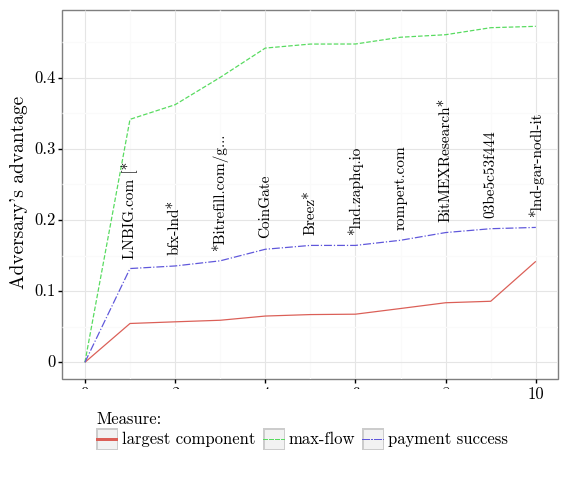

<ggplot: (8794196130301)>

In [14]:
# Plot Figure 7
# combine max flow, expected payment sucess, and component disintegration
# Note that the legend and some of the labels of this plot have been improved manually in the paper itself
combined = mfResultsDF.rename(columns={"advantage":"max-flow"}).merge(
    psResultsDF.rename(columns={"advantage":"payment success"}), on=["cluster", "index"]).merge(
    removalStats, on=["cluster", "index"])
combined = combined.merge(cluster_aliases, how="left")
combined_for_plot = pd.melt(combined ,id_vars=["index", "alias"], value_vars=["max-flow", "payment success", "largest component"])
combined_for_plot = combined_for_plot[combined_for_plot["index"] <= 10]
plot = ggplot(combined_for_plot) +\
geom_line(aes(x="index", y="value", color="variable", linetype="variable")) +\
geom_text(data=combined_for_plot[combined_for_plot.variable == "payment success"],
          mapping=aes(x="index", y="value", label="alias"), angle=90, va="baseline", nudge_y=0.02) +\
theme_publication +\
scale_x_continuous(breaks=[0,2,4,6,8,10]) +\
labs(x="Number of removed entities by capacity share", y="Adversary's advantage", color="Measure:", linetype="Measure:") +\
theme(legend_position="bottom")

plot.save("combined-max-flow-payment-success-component.pdf", width=5, height=3.5)
plot